In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr
import sklearn
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
%run BankPreprocess.ipynb

C:\Users\cdjs\AppData\Local\Temp\ipykernel_70348\3447305422.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df[col] = num_df[col].replace(-1, pd.NA)
C:\Users\cdjs\AppData\Local\Temp\ipykernel_70348\3447305422.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df[col] = num_df[col].fillna(base_df[col].mean())


In [3]:
ord_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      45211 non-null  int64
 1   job                      45211 non-null  int64
 2   marital                  45211 non-null  int64
 3   education                45211 non-null  int64
 4   has_defaulted            45211 non-null  int64
 5   balance                  45211 non-null  int64
 6   housing                  45211 non-null  int64
 7   loan                     45211 non-null  int64
 8   contact                  45211 non-null  int64
 9   day                      45211 non-null  int64
 10  month                    45211 non-null  int64
 11  duration                 45211 non-null  int64
 12  campaign                 45211 non-null  int64
 13  days_since_last_contact  45211 non-null  int64
 14  prev_contact_count       45211 non-null  int64
 15  pr

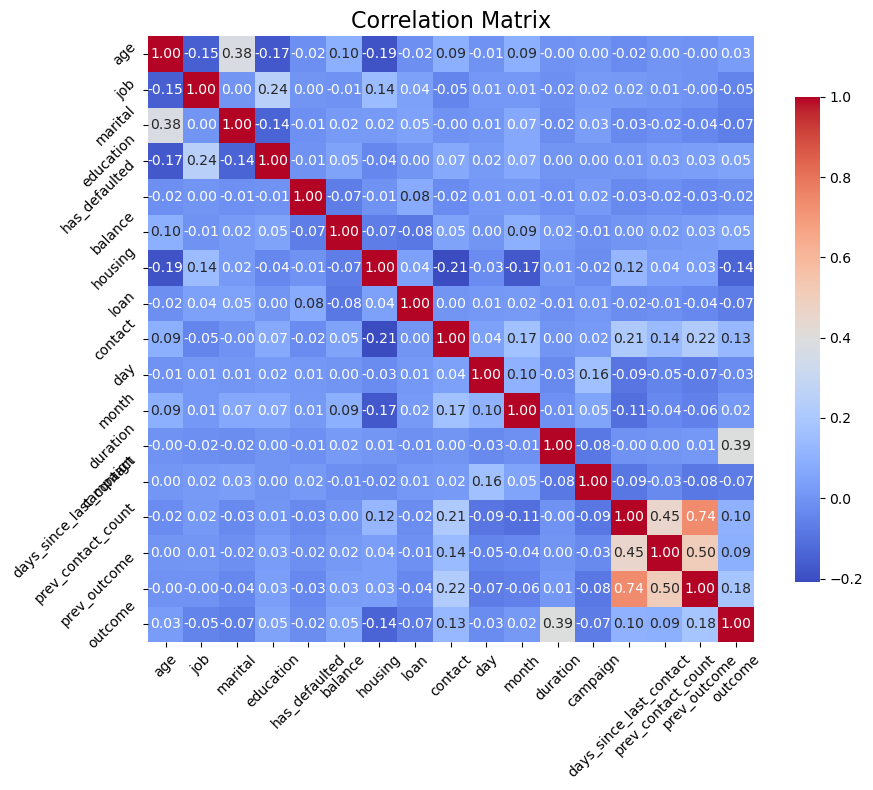

Top 10 Most Strongly Correlated Features:
prev_outcome             days_since_last_contact    0.736612
days_since_last_contact  prev_outcome               0.736612
prev_contact_count       prev_outcome               0.503637
prev_outcome             prev_contact_count         0.503637
prev_contact_count       days_since_last_contact    0.454820
days_since_last_contact  prev_contact_count         0.454820
duration                 outcome                    0.394521
outcome                  duration                   0.394521
age                      marital                    0.376104
marital                  age                        0.376104
dtype: float64


In [4]:
# Preprocess

# Calculate the correlation matrix
correlation_matrix = ord_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set titles and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#  Reduce Dimensionality by getting top x corelated features
# we should use decision tree to rank features, better correlated features doesn't mean better outcome
# random forest is able to do feature interactions, check how different features interact with each other
# with random forest we may not need pca to reduce dimensionality because random forest can handle the feature selection
# may not want to reduce feature using pca, also loose interpretability
# Get the absolute values of the correlation matrix
abs_corr = correlation_matrix.abs()

# Unstack the matrix to get a Series
corr_pairs = abs_corr.unstack()

# Drop self-correlations (where the index and columns are the same)
corr_pairs = corr_pairs[corr_pairs < 1]

# Sort the pairs by correlation values in descending order
sorted_pairs = corr_pairs.sort_values(ascending=False)

# Get the top 5 most strongly correlated pairs
top_10 = sorted_pairs.head(10)

print("Top 10 Most Strongly Correlated Features:")
print(top_10)

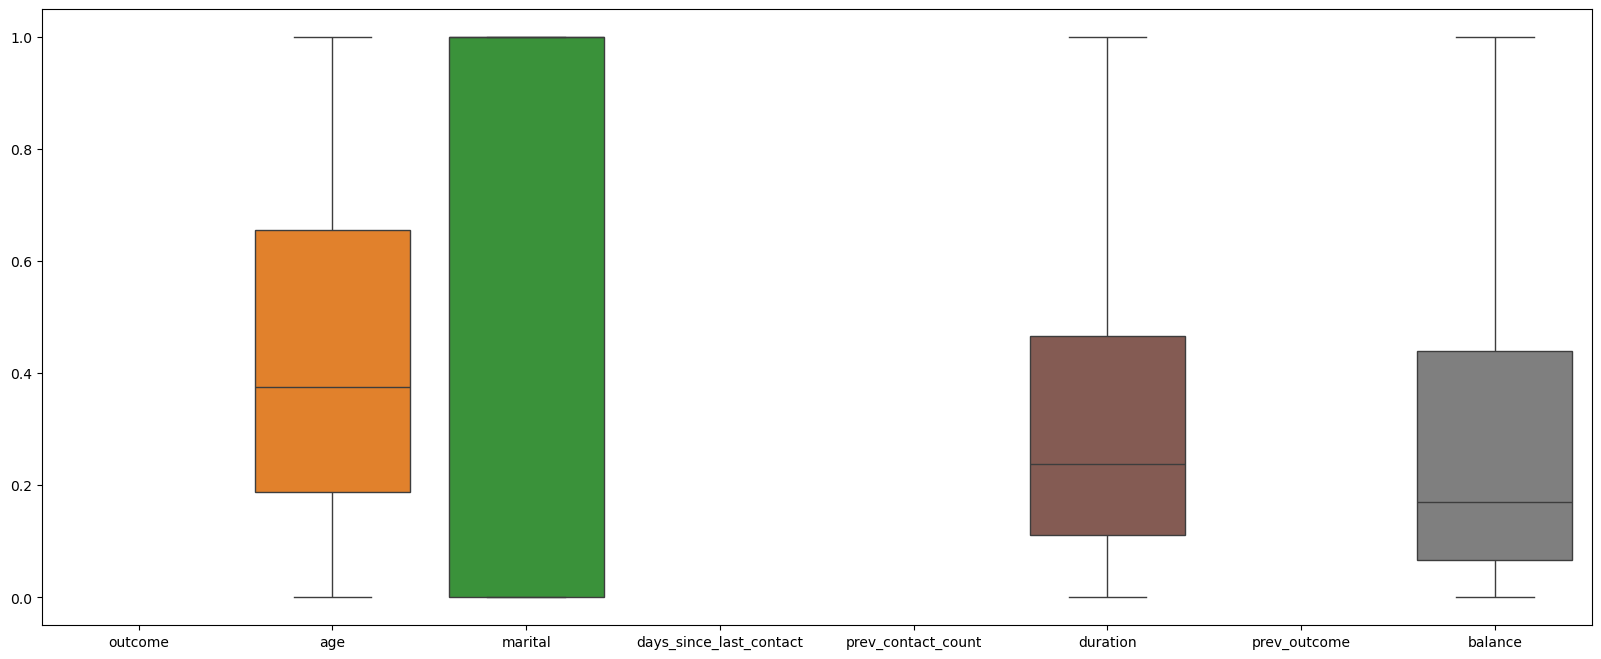

In [5]:

# Extract unique columns from the top 5 pairs
top_10_columns = set()
for index in top_10.index:
    top_10_columns.update(index)

# Convert set to list
top_10_columns = list(top_10_columns)

# Drop all columns not in top 10
new_df = ord_df[top_10_columns]
new_df = pd.concat([new_df, ord_df['balance']],axis=1)

# Iterate through each numerical column to check for outliers and normalize
for col in new_df.select_dtypes(include='number').columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = new_df[col].quantile(0.25)
    Q3 = new_df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Determine outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers by clipping
    new_df[col] = new_df[col].clip(lower_bound, upper_bound)

    # Calculate the 5th and 95th percentiles for normalization
    p5 = new_df[col].quantile(0.05)
    p95 = new_df[col].quantile(0.95)

    # Normalize the data
    new_df[col] = (new_df[col] - p5) / (p95 - p5)

    # Clip normalized values to [0, 1]
    new_df[col] = new_df[col].clip(0, 1)


fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=new_df,ax=ax)
plt.show()

In [6]:
# Hindsight trying to predict age from the financial data, marriage, duration and balance is not meaningful, however model performs better predicting age than balance on this dataset. We are able to visualise NA Values as absent in boxplot above so we can drop the NA features. We could add a method to allow mix max normalisation to retain na features but this isn't a priority for this assessment. 

# Assign the 'balance' column to y
y = new_df['age']

# Drop the 'balance' column and assign the result to X
X = new_df.drop(['days_since_last_contact','age', 'prev_contact_count', 'prev_outcome', 'outcome'], axis=1)

In [7]:
# X.info()
X.head()

,marital,duration,balance
0,1.0,0.371711,0.637039
1,0.0,0.190789,0.055311
2,1.0,0.067434,0.047881
3,1.0,0.093750,0.461750
4,0.0,0.268092,0.047606


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA, we are turning 3 features into 2 features to reduce the dimensionality. PCA can be applied here as we don't need to preserve original structure of data, interpretability of features is not important and features have the same scales.
pca = PCA(n_components=2)  # Retain the first 2 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [ ]:
# Set up the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'rbf']
}

# Initialize the SVM model
svm = SVR(C=0.1,epsilon=0.1,kernel="rbf")
svm.fit(X_train_pca, y_train)
# Calculate MSE
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_pca, y_train)

# Best parameters from grid search
print("Best parameters found: ", grid_search.best_params_)

In [ ]:

# Use the best model to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
print(best_model.score(X_test_pca, y_test))
evaluate_model(best_model, X_test_pca, y, kind='Regression')

# We could also look into using ROC Curves to visualise the different results of models and compare during kfold. 